Loading the data

In [25]:
import numpy as np
import pandas as pd

normalized_df = pd.read_excel('data.xlsx', sheet_name='normalized_data')
data_set = normalized_df.to_numpy()

weights = np.array([0.09, 0.01, 0.03, 0.05, 0.001, 0.09, 0.16, 0.08, 0.03, 0.02, 0.06, 0.04, 0.09, 0.04, 0.029, 0.18])
threshold_concordance = 0.5  # Choosing an threshold
criteria_names = normalized_df.columns[1:]  # Excluding the 'Country Name' column
veto_values = np.array([0, 0.6, 0, 0.8, 0.5, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1])

print(veto_values)

Index(['Agriculture, forestry, and fishing, value added (% of GDP)',
       'Births attended by skilled health staff (% of total)',
       'CO2 emissions (metric tons per capita)(MAX)',
       'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'GNI per capita, Atlas method (current US$)',
       'Industry (including construction), value added (% of GDP)',
       'Life expectancy at birth, total (years)',
       'Population growth (annual %)',
       'Poverty headcount ratio at $2,15 a day MAX',
       'Revenue, excluding grants',
       'Time required to start a business (days)'],
      dtype='object')
[0.  0.6 0.  0.8 0.5 0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]


weights : [0.09, 0.01, 0.03, 0.05, 0.001, 0.09, 0.16, 0.08, 0.03, 0.02, 0.06, 0.04, 0.09, 0.04, 0.029, 0.18]

Veto values : [0.  0.6 0.  0.8 0.5 0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]


Concordance matrix :

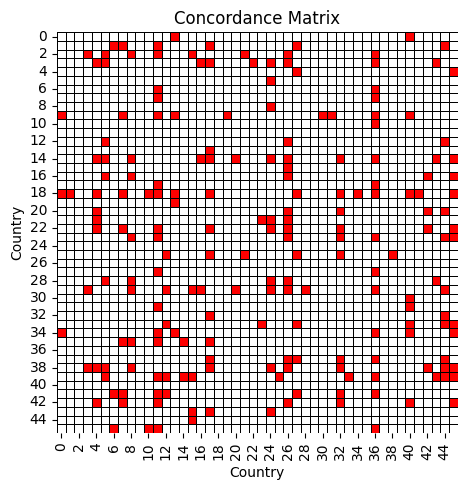

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

concordance_matrix = np.zeros((len(data_set), len(data_set)))

for i in range(len(data_set)):
    for j in range(len(data_set)):
        if i == j:
            continue
        
        sum_weights_a = 0
        for k, criteria in enumerate(criteria_names):
            if data_set[i][k+1] > data_set[j][k+1]:
                sum_weights_a += weights[k]

        if sum_weights_a > threshold_concordance:
            concordance_matrix[i, j] = 1

# Creating a custom colormap with two colors
cmap = sns.color_palette(['white', 'red'])

# Creating a heatmap plot
plt.figure(figsize=(5, 5))
sns.heatmap(concordance_matrix, cmap=cmap, linewidths=0.5, linecolor='black', square=True, cbar=False)

# Customizing the plot
plt.xlabel('Country')
plt.ylabel('Country')
plt.title('Concordance Matrix')

# Adjusting plot settings
plt.tight_layout()

# Show the plot
plt.show()


Discordance matrix :

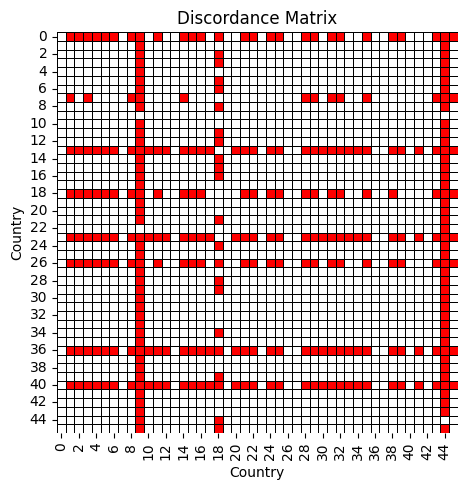

In [22]:
discordance_matrix = np.zeros((len(data_set), len(data_set)))

for i in range(len(data_set)):
    for j in range(len(data_set)):
        if i == j:
            continue

        for k in range(len(criteria_names)):
            if veto_values[k] == 0:
                continue

            if data_set[j][k+1] - data_set[i][k+1] > veto_values[k]:
                discordance_matrix[i, j] = 1
                break

# Creating a custom colormap with two colors
cmap = sns.color_palette(['white', 'red'])

# Creating a heatmap plot
plt.figure(figsize=(5, 5))
sns.heatmap(discordance_matrix, cmap=cmap, linewidths=0.5, linecolor='black', square=True, cbar=False)

# Customizing the plot
plt.xlabel('Country')
plt.ylabel('Country')
plt.title('Discordance Matrix')

# Adjusting plot settings
plt.tight_layout()

# Show the plot
plt.show()


Find the countries surpassed by each country

['Algeria', 'Argentina', 'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Croatia', 'Cuba', 'Denmark', 'Egypt, Arab Rep,', 'Finland', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Israel', 'Italy', 'Japan', 'Korea, Rep,', 'Kuwait', 'Luxembourg', 'Malta', 'Mexico', 'Netherlands', 'Norway', 'Paraguay', 'Peru', 'Portugal', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Tunisia', 'Turkiye', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay']


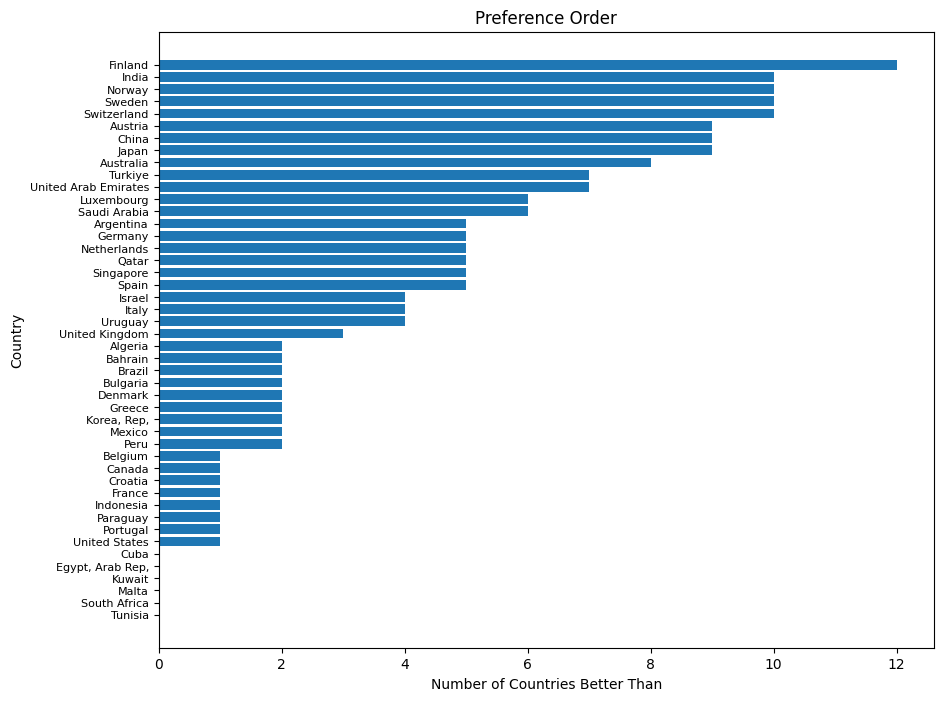

In [24]:
preference_order = []

for i in range(len(data_set)):
    country_i = data_set[i][0]
    better_than_i = []
    
    for j in range(len(data_set)):
        if i != j:
            country_j = data_set[j][0]
            
            if concordance_matrix[i][j] == 1 and discordance_matrix[i][j] == 0:
                better_than_i.append(country_j)
        
    preference_order.append((country_i, better_than_i))

# Sorting the preference order based on the number of countries each country is better than
preference_order.sort(key=lambda x: len(x[1]), reverse=True)

# Extracting the sorted country list
sorted_country_list = [x[0] for x in preference_order]

import matplotlib.pyplot as plt

# Creating a bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_country_list)), [len(better_than) for _, better_than in preference_order[::-1]])

# Customizing the plot
plt.yticks(range(len(sorted_country_list)), sorted_country_list[::-1])
plt.xlabel('Number of Countries Better Than')
plt.ylabel('Country')
plt.title('Preference Order')
plt.yticks(fontsize=8)
# Show the plot
plt.show()

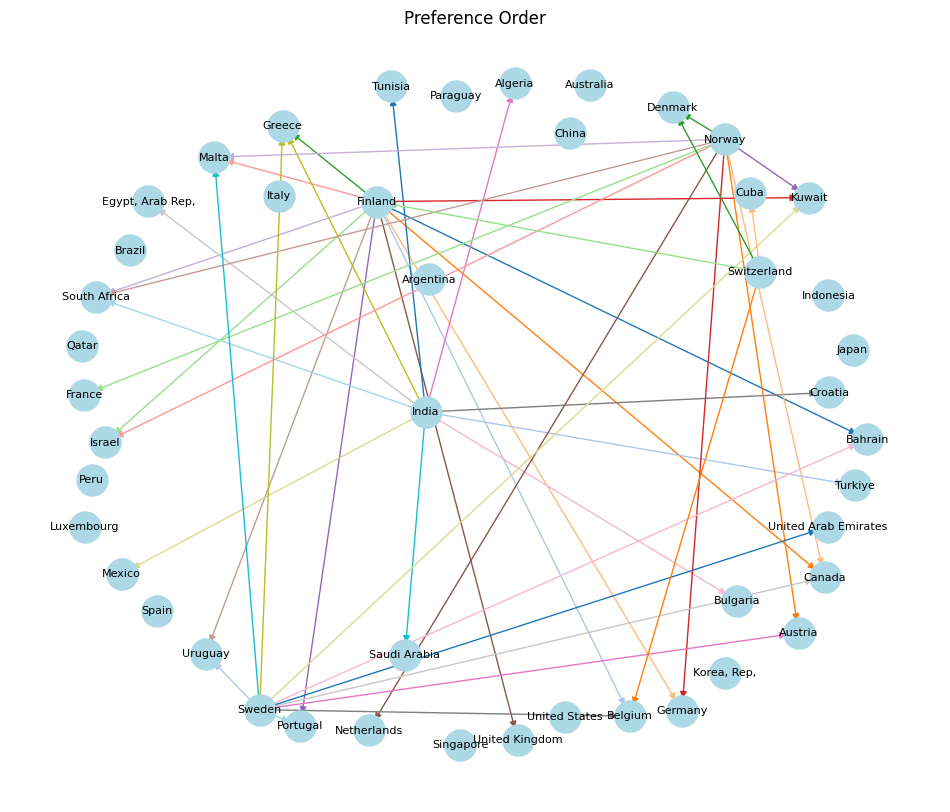

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Creating a directed graph
G = nx.DiGraph()

# Adding nodes (countries) to the graph
for country, _ in preference_order:
    G.add_node(country)

# Adding edges (arrows) based on the preference order
for country, better_than in preference_order:
    for other_country in better_than:
        G.add_edge(country, other_country)

# Setting the layout with adjusted spacing
pos = nx.spring_layout(G, k=2.5)

# Setting the figure size
plt.figure(figsize=(12, 10))

# Generating country-specific colors for arrows
color_map = plt.get_cmap('tab20')
arrow_colors = [color_map(i % 20) for i in range(len(preference_order))]

# Drawing nodes and edges with custom arrow colors
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
for (u, v), color in zip(G.edges(), arrow_colors):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color, arrows=True)

# Adding labels to the nodes
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Adjusting plot settings
plt.axis('off')
plt.title('Preference Order')

# Show the plot
plt.show()

In [11]:
best_options = []

for i in range(len(data_set)):
    country_i = data_set[i][0]
    is_best = True
    
    for j in range(len(data_set)):
        if i != j:
            country_j = data_set[j][0]
            
            if concordance_matrix[i][j] == 0 or discordance_matrix[i][j] == 1:
                is_best = False
                break
    
    if is_best:
        best_options.append(country_i)

if (len(best_options)==0):
    print("No best option : no dominant country")

No best option : no dominant country


There is no dominant country

Calculating [dominted coutries - dominating coutries] for each coutry

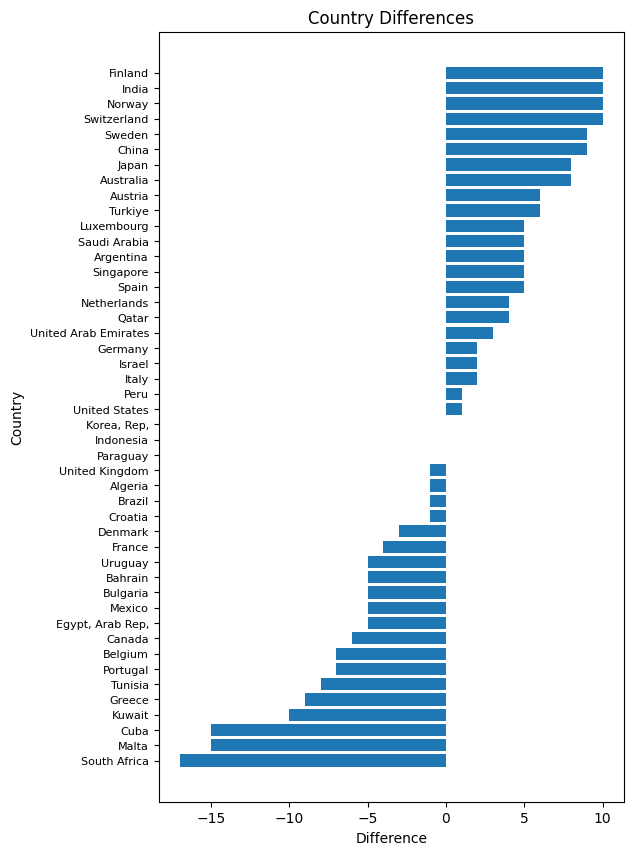

In [9]:
country_differences = []
for country, better_than in preference_order:
    countries_better_than_country = len(better_than)
    countries_better_than_it = sum(country in b for _, b in preference_order)
    difference = countries_better_than_country - countries_better_than_it
    country_differences.append((country, difference))

# Sorting country_differences in descending order based on the difference values (starting with the maximum)
country_differences.sort(key=lambda x: x[1], reverse=True)

import matplotlib.pyplot as plt
# Extracting the country names and difference values for plotting
countries = [country for country, _ in country_differences][::-1]
differences = [difference for _, difference in country_differences][::-1]

plt.figure(figsize=(6, 10))
# Plotting the country differences
plt.barh(countries, differences)
plt.xlabel('Difference')
plt.ylabel('Country')
plt.title('Country Differences')
plt.yticks(fontsize=8)
plt.show()